---
title: "Mapping 2025 Eaton and Palisades fires: Environmental and social impacts"
description: "Examining the effects of the 2025 Eaton and Palisades fires on ecosystems and communities through remote sensing"
author:
  - name: Aakriti Poudel
    url: https://aakriti-poudel-chhetri.github.io/
date: 2025-11-29
format:
  html:
    code-fold: true
    embed-resources: true
jupyter: eds220-env    
citation: 
  url: https://aakriti-poudel-chhetri.github.io/posts/2025-12-eaton-palisades-fires-eji/
categories: [MEDS, geospatial, python, eji]
image: eaton-palisades-fires.png
draft: false
bibliography: references.bib
---

Link to GitHub repository:

-   For environmental monitoring, <https://github.com/aakriti-poudel-chhetri/eds220-hwk4>
-   For social impact analysis, <https://github.com/aakriti-poudel-chhetri/eds220-2025-discussion-sections/blob/main/week8-eaton-and-palisades-fire.ipynb>

## About this blog post

The Eaton and Palisades fires, which ignited almost simultaneously in early January 2025, showed not only the ecological vulnerability of Los Angeles County’s foothill and coastal wild-land urban interface zones but also the deep social dimensions embedded within wildfire disasters. Using remote sensing tools such as Landsat based false color imagery, environmental monitoring efforts can clearly delineate burn severity, vegetation loss and fire scar patterns that acts as critical information for assessing ecological recovery and guiding restoration. Yet the impacts of these fires extended far beyond the physical landscape. Thousands of homes were destroyed, tens of thousands of residents were displaced, and long standing inequities shaped who suffered most, who could rebuild and how quickly communities could recover. Factors such as income level, housing security, access to insurance, language barriers, transportation availability, and trust in public institutions strongly influenced how individuals responded to evacuation orders, accessed emergency services, and navigated post-fire assistance. By integrating advanced data visualization with an understanding of these social realities, environmental monitoring becomes not only a scientific exercise but also a tool for informing more just, community-centered wildfire resilience planning

This analysis combines the environmental monitoring with social vulnerability data to show how the Eaton and Palisades fires affected both the natural landscape and the communities living within it.

## Highlights

The analysis illustrates Python-based approaches for geospatial investigation:

-   Use `xarray` and `rioxarray` to create false-color images from Landsat 8 SWIR, NIR, and Red bands, revealing burn scars.
-   Combine raster satellite data with vector layers (fire perimeters and census tracts) in `geopandas` to integrate multiple data sources.
-   Maintain spatial accuracy by managing coordinate reference systems with `rio.write_crs()` and `to_crs()`.
-   Perform environmental justice analysis by using spatial joins and clipping to examine socioeconomic vulnerability in the burn-affected areas.

## Dataset descriptions

#### Simplified collection of bands from the Landsat Collection 2 Level-2\*\*

This dataset is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was retrieved from the [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and clipped to an area surrounding the fire perimeters.

#### Fire perimeters for the Eaton and Palisades fires\*\*

This dataset is dissolved fire perimeters/boundaries for Eaton and Palisades fires. The data can be accessed from the [County of Los Angeles Open Data](https://data.lacounty.gov/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about).

#### Environmental Justice Index (EJI) Data

The 2024 [California Environmental Justice Index (EJI)](https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html), developed by the CDC and ATSDR, offers census tract-level information on both environmental and socioeconomic factors. This analysis utilizes the dataset to examine demographic characteristics, poverty levels, and environmental burden indicators across communities in California.

#### Setup

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

## Analysis 1: Visualizing fire scars through false color

### Data analysis sections

#### Import fire perimeter data

Fire perimeter data define the spatial extent of the fires, enabling focused analysis on the most impacted areas. Each dataset includes polygon geometries representing the fire boundaries, along with corresponding area and perimeter measurements.

In [2]:
# Use geopandas.read_file() to read the file
eaton = gpd.read_file("data/Eaton_Perimeter_20250121/Eaton_Perimeter_20250121.shp")
palisades = gpd.read_file("data/Palisades_Perimeter_20250121/Palisades_Perimeter_20250121.shp")

In [3]:
#| label: fire-perimeter-summary
#| echo: false

# Create summary table for data exploration
summary_data = {
    'Dataset': ['Eaton Fire', 'Palisades Fire'],
    'Features': [len(eaton), len(palisades)],
    'Columns': [len(eaton.columns), len(palisades.columns)],
    'Geometry Type': [eaton.geometry.type.unique()[0], palisades.geometry.type.unique()[0]]
}

summary_df = pd.DataFrame(summary_data)

# Display as formatted table
#display(Markdown(summary_df.to_markdown(index=False)))

print(summary_df.to_markdown(index=False))

| Dataset        |   Features |   Columns | Geometry Type   |
|:---------------|-----------:|----------:|:----------------|
| Eaton Fire     |         20 |         5 | Polygon         |
| Palisades Fire |         21 |         5 | Polygon         |


The `eaton` and `palisades` datasets both have 5 columns (`OBJECTID`, `type`, `Shape_Are`, `Shape_Len` and `geometry`) with the same data types. The data types used are appropriate for all values in their respective columns. There is no missing data in the column. There are 20 rows in `eaton` dataset and 21 rows in `palisades` dataset.

Both of the dataset has same `CRS (EPSG:3857)`, which is **projected coordinate system** that uses the Mercator projection to display the spherical Earth on a flat map.

#### Import NetCDF data

In [4]:
# Import the Landsat data using xr.open_dataset().
landsat = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc")
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

**Summary of the NetCDF dataset**

This dataset is a remote sensing raster dataset loaded as `xarray.Dataset`. The total size of the dataset is 78MB. The dataset exploration gave an information on dimensions, coordinates nad data variables.

There are two spatial dimensions on dataset. The (y: 1418) represents the vertical spatial dimension (rows) and (x: 2742) represents the horizontal spatial dimension (columns).

The dataset has coordinate arrays for both x and y, stored as float64 values that corresponds to their respective spatial map coordinates. There is a only one time coordinate stored as datetime64\[ns\], that indicates when the image was taken.

There are five different spectral bands: red, green, blue, nir08 and swir22, and they have the same pixel grid (float32). A spatial_ref variable is also included to store the map projection information.

#### Restoring geospatial information

In [5]:
# Recover the geospatial information and spatial reference information
print(landsat.rio.write_crs(landsat.spatial_ref.crs_wkt, inplace=True))

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...


## Visualize Eaton and Palisades fires

#### Create a True color image

To create a true-color image from the Landsat dataset, select the red, green, and blue bands, in that order, directly from the existing `xarray.Dataset` without creating any new variables. Then convert these bands into a NumPy array using the `to_array()` method and `use .plot.imshow()` to display them as an RGB image. Two warnings appear during this step, but they are okay to ignore. Finally, adjust the plotting scale, using the robust parameter to handle extreme values, since clouds act as outliers and can compress the contrast of the image if not corrected.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


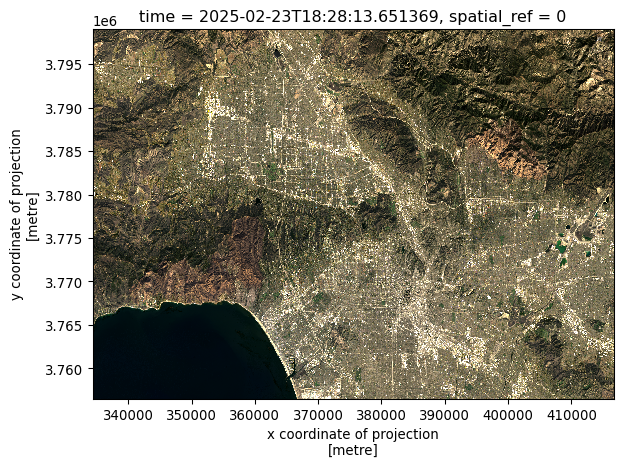

In [6]:
# Select the red, green and blue variables, convert it to a numpy.array and create an RGB image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

Resolve the other warning, identify which bands have nan values. Here, we  use numpy.isnan().

In [7]:
# Identify 'nan' values in bands
for i in ['red', 'green', 'blue']:
    # .isnull() creates a boolean array (True where NaN)
    # .sum() sums the True values (counts the NaNs)
    # .item() converts the single result to a standard Python integer
    nan_count = landsat[i].isnull().sum().item()
    print(f"The {i} band has {nan_count} Nan values.")

The red band has 0 Nan values.
The green band has 1 Nan values.
The blue band has 109 Nan values.


Use the `.fillna()` mehtod for `xarray.Dataset` to substitute the any nan values in the Landsat data for zero.

In [8]:
# Substitute any 'nan' values in the Landsat data for zero
landsat = landsat.fillna(0)

Create a new true color image that gets plotted without warnings.

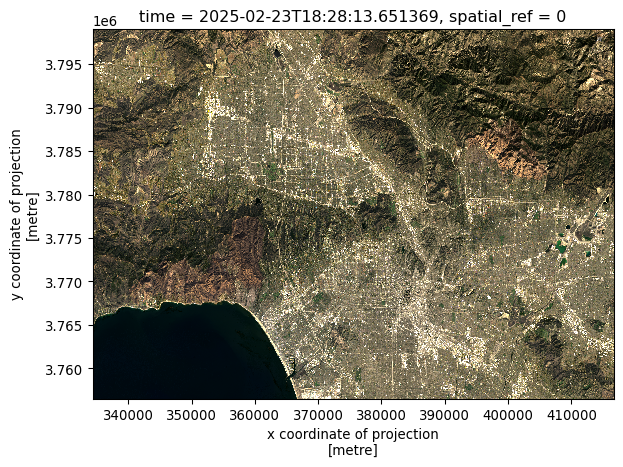

In [9]:
# Create a new true color image without warnings
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

#### A brief explanation comparing the outputs.

The first true color image (part a) was plotted directly from the red, green and blue bands without modifying the dataset. The image worked, but we got warnings because some of the data had Nan (missing) values. These missing values caused problems during plotting. Additionally, due to the presence of very bright cloud pixels, many of the other colors appeared darker or washed out, even when using the robust=True to ignore extreme outliers.

In part (part e), we replaced all Nan values with zeros before plotting again. This removed the missing values issue allowing the plot to scale the data more smoothly. So, the second true color image displayed without warnings. The second true color image looks cleaner and has better contrast. It doesn’t have the plotting problems seen in the first image.

#### Create a False color image

To create a false-color image, you select the short-wave infrared (swir22), near-infrared and red bands, in that order, directly from the dataset without making any new variables, and then plot them together as an RGB image.

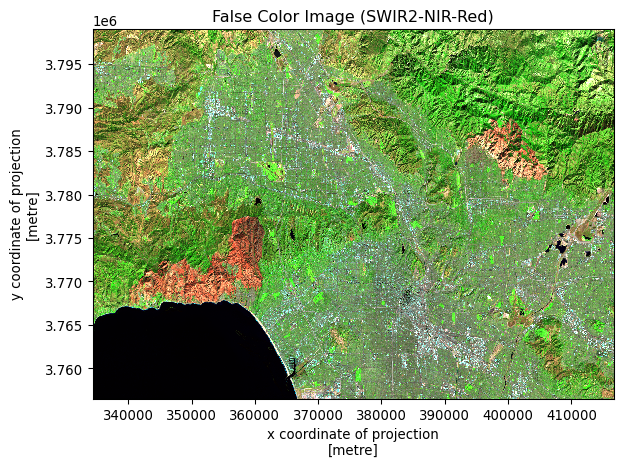

In [10]:
# Create false color image (SWIR2, NIR, Red)
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
plt.title('False Color Image (SWIR2-NIR-Red)')
plt.show()

#### Create a False color image for Eaton and Palisades fires

Create a map by plotting the shortwave infrared/near-infrared/red false-color image and overlay both fire perimeters on top of it. Customize the map with an informative title and a clear legend, and you may also add text labels directly on the map to identify which fire boundary corresponds to which fire.

In [11]:
# Combine the two fire perimeter datasets into a single GeoDataFrame
fires = pd.concat([eaton, palisades], ignore_index = True)

# Convert CRS of the Eaton and Palisades fire perimeter to landsat dataset CRS
fires = fires.to_crs('epsg:32611')

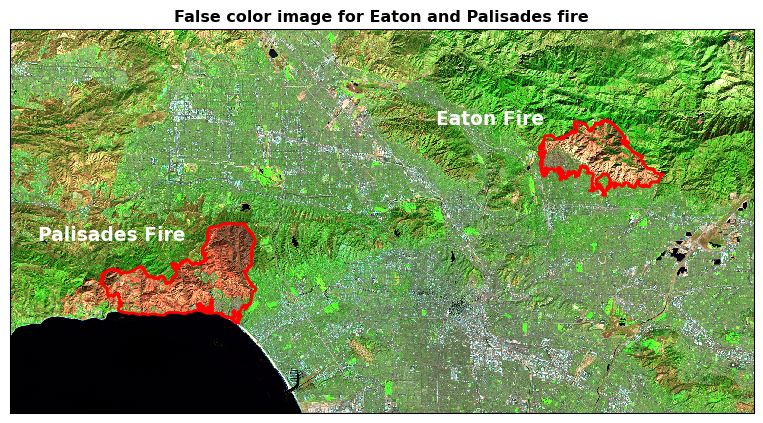

In [12]:
# Initialize the map
fig, ax = plt.subplots(figsize = (10, 8))

# Plot the false color map
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True,
                                                           ax = ax,
                                                           add_colorbar = False)

# Plot fires perimeter on false color map
fires.boundary.plot(ax = ax, color = 'red', linewidth = 2)

# Add text for first fire (adjust index and name as needed)
ax.text(fires.geometry.centroid.x.values[0] - 11000, fires.geometry.centroid.y.values[0] + 8000, 'Eaton Fire',
        fontsize = 14, weight = 'bold', color = 'white', ha = 'center', va = 'center')

# Add text for second fire (adjust index and name as needed)
ax.text(fires.geometry.centroid.x.values[-1] - 9000, fires.geometry.centroid.y.values[-1] + 5000, 'Palisades Fire', 
        fontsize = 14, weight = 'bold', color = 'white', ha = 'center', va= 'center')

# Add title to the map
plt.title('False color image for Eaton and Palisades fire', fontsize = 12, weight = 'bold')

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")

# Add a scalebar
#ax.add_artist(ScaleBar(1, box_color="white",location="lower left"))

plt.show()

**Description for the map including a brief explanation of how false color imagery is being used.**

This map shows a false color image made from Landsat data for Eaton and Palisades fire of the Los Angeles County. The map uses three bands: SWIR2, NIR and Red, assigned to the red, green and blue color channels. In this image, vegetation looks green because they reflect a lot of near-infrared light. The fire burned areas and bare ground looks brown. The urban areas usually appear purple or gray. The water looks black. The boundaries of the Eaton Fire and Palisades fire are delineated with red outlines. Each fire is labeled.

This combination of bands is useful for spotting burn scars and understanding fire damage because SWIR2 reacts strongly to moisture changes, and NIR highlights how healthy the vegetation is. Together, these bands make it easy to see where fires have changed the landscape.

## Analysis 2: Social dimensions of Eaton and Palisades fires

The Environmental Justice Index (EJI) highlights the social dimensions of wildfire impacts, revealing how vulnerable communities are disproportionately affected. These maps provide clear visualizations of factors such as age, health, and economic vulnerability, helping to identify populations most at risk and the underlying patterns of environmental injustice in each county.

### Data analysis sections

In [13]:
# Load census tract-level socioeconomic data
eji = gpd.read_file("data/EJI_2024_California/EJI_2024_California.gdb")
# Convert CRS of `eji` to match eaton and palisades perimeter data
eji = eji.to_crs(crs = 'epsg:3857')

Here, we combine Environmental Justice Index (EJI) data with the Eaton and Palisades fire perimeters to analyze the social dimensions of fire impacts. First, a spatial join `gpd.sjoin` gives all EJI polygons that intersect each fire, keeping full census tracts that are affected. Next, the `gpd.clip` function trims these polygons to the exact area within the fire boundaries, allowing for precise calculations of vulnerability metrics confined to the burned regions.

In [14]:
#| echo: false
#| output: false

# Spatially join the EJI data with the palisades
palisades_eji = gpd.sjoin(eji, palisades, how = "inner")
eaton_eji = gpd.sjoin(eji, eaton, how = "inner")

# Clip the census tracts to the Palisades fire perimeter
palisades_clip = gpd.clip(eji, palisades)
eaton_clip = gpd.clip(eji, eaton)

### Visualizations of the social impacts of fires

The social dimension of wildfire risk is closely tied to population vulnerability, particularly among elderly residents. In the Environmental Justice Index, the percentage of populations aged 65 and older 'E_AGE65' indicate the proportion of seniors within a community relative to others (0–100 scale). This metric matters for wildfire preparedness and response because older adults often face mobility limitations, pre-existing health conditions, and greater reliance on assistance for evacuation. They may also experience longer recovery times following fire events.

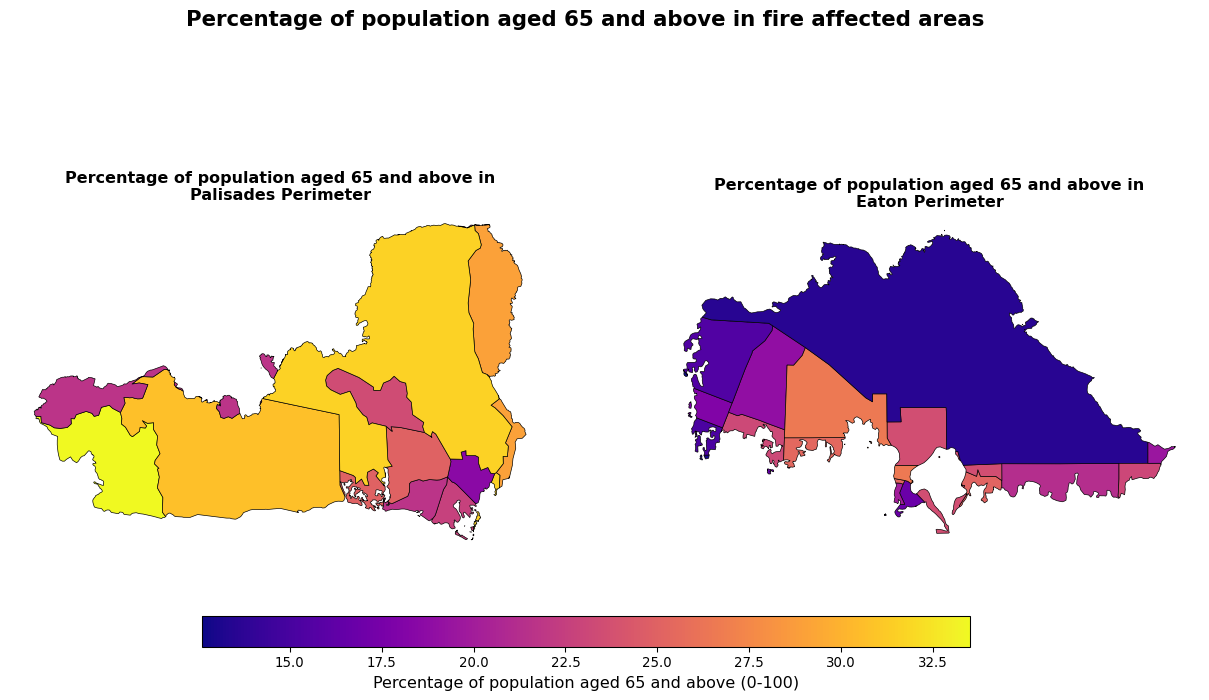

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Update with the eji variable
eji_variable = 'E_AGE65'

# Find common min/max for legend range
vmin = min(palisades_clip[eji_variable].min(), eaton_clip[eji_variable].min())
vmax = max(palisades_clip[eji_variable].max(), eaton_clip[eji_variable].max())

# Plot census tracts within Palisades perimeter
palisades_clip.plot(column= eji_variable, cmap='plasma', vmin=vmin, vmax=vmax, legend=False, ax=ax1, edgecolor='black', linewidth=0.5)
ax1.set_title('Percentage of population aged 65 and above in\nPalisades Perimeter',
              fontsize=12, fontweight='bold')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eaton_clip.plot(column=eji_variable, cmap='plasma', vmin=vmin, vmax=vmax, legend=False, ax=ax2, edgecolor='black', linewidth=0.5)
ax2.set_title('Percentage of population aged 65 and above in\nEaton Perimeter',
              fontsize=12, fontweight='bold')
ax2.axis('off')

# Add overall title
fig.suptitle('Percentage of population aged 65 and above in fire affected areas',
             fontsize=16, fontweight='bold')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.04])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentage of population aged 65 and above (0-100)',
               fontsize=12)

plt.show()

## References

*Landsat Collection 2 Level-2*. Microsoft Planetary Computer. Retrieved 15 Nov, 2025. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2.

*Palisades and Eaton Dissolved Fire Perimeters*. (2025) County of Los Angeles Open Data. https://data.lacounty.gov/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about.

*Why Is That Forest Red and That Cloud Blue?*. (2014, March 4). NASA Earth Observatory. https://earthobservatory.nasa.gov/features/FalseColor.

*What Are the Band Designations for the Landsat Satellites?*.(2025, July 11). U.S. Geological Survey. https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites.

*Common Landsat Band Combinations*. (2021, November 12). U.S. Geological Survey. https://www.usgs.gov/media/images/common-landsat-band-combinations

*Centers for Disease Control and Prevention, and Agency for Toxic Substances and Disease Registry*. (2024) Environmental Justice Index. https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html.